# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 9. Байесовские классификаторы.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. 
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком
    * *или* вставив ее в ноутбук посредством `Edit -> Insert Image` при редактировании markdown-ячейки (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). **<font color="red">Неправильно вставленные фотографии могут не передаться при отправке.</font>** Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* **В решениях поясняйте, чем вы пользуетесь**, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 1 &mdash; 30 баллов
* Задача 2 &mdash; 28 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline
from collections import Counter

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [2]:
from sklearn.datasets import fetch_20newsgroups
import warnings
warnings.simplefilter("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

---
### Задача 1.

На занятии мы уже научились классифицировать текстовые сообщения на нормальные и спам. Теперь перед вами стоит более серьезная задача &mdash; построить систему, автоматически классифицирующую поступающие новостные сюжеты на несколько заранее заданных категорий.
 
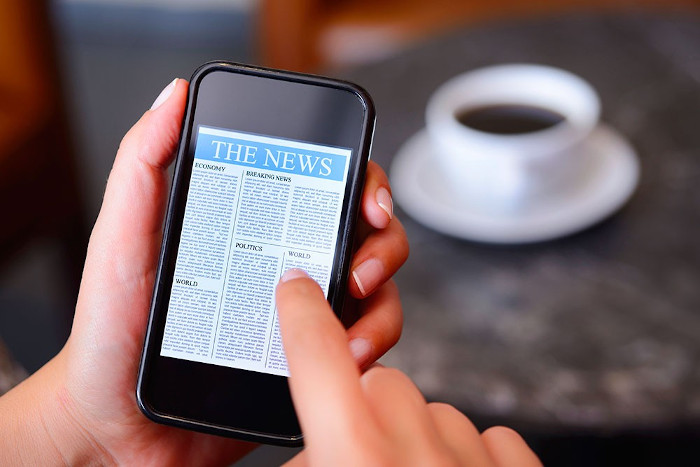



Перед выполнением задачи обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [3]:
# удаляем заголовки и подписи
remove = ('headers', 'footers')
# зафиксируем зерно случайности
random_state = 42

# Извлекаем обучающую и тестовую части перемешивая случайным образом
data_train = fetch_20newsgroups(
    subset='train', shuffle=True, random_state=random_state, remove=remove
)
data_test = fetch_20newsgroups(
    subset='test', shuffle=True, random_state=random_state, remove=remove
)

Посмотрим на какое-нибудь сообщение

In [4]:
print(data_train['data'][21])

In article <1993Apr20.151818.4319@samba.oit.unc.edu> Scott.Marks@launchpad.unc.edu (Scott Marks) writes:
>>And of course, Mike Ramsey was (at one time) the captain in Buffalo prior to
>>being traded to Pittsburgh.  Currently, the Penguins have 3 former captains
>>and 1 real captain (Lemieux) playing for them.  They rotate the A's during the
>>season (and even the C while Mario was out).  Even Troy Loney has worn the C
>>for the Pens.
>

I think that Mike Foligno was the captain of the Sabres when he
got traded to the Leafs. Also, wasn't Rick Vaive the captain of
the Leafs when he got traded to Chicago (with Steve Thomas for
Ed Olcyzk and someone). Speaking of the Leafs, I believe that
Darryl Sittler was their captain (he'd torn the "C" off his
jersey but I think he re-claimed the captaincy later on) when he
was traded to the Flyers.

Oh yeah, of course, Gretzky was the captain of the Oilers before
he was traded wasn't he? 


Индекс тематической группы для каждого сообщения

In [5]:
data_train['target']

array([7, 4, 4, ..., 3, 1, 8])

Названия тематических групп

In [6]:
data_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

С помощью методов, изученных в рамках нашего курса, постройте классификатор новостных сюжетов на тематические группы. При построении классификатора **запрещено пользоваться тестовой выборкой**. Для настройки классификатора, например, выбора оптимальных гиперпараметров, можно разделить обучающую выборку на две части &mdash; непосредственно обучающую и валидационную. Первую часть использовать для непосредственного обучения, а вторую &mdash; для настройки, пытаясь по ней оптимизировать качество.

In [7]:
data1 = pd.DataFrame({'news': data_train.data,'target': data_train.target}) 
data1.head()

,news,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [8]:
train, val = train_test_split(data1, train_size=0.8, random_state=random_state)

Посмотрим на количество новостей в каждом классе

<Axes: >

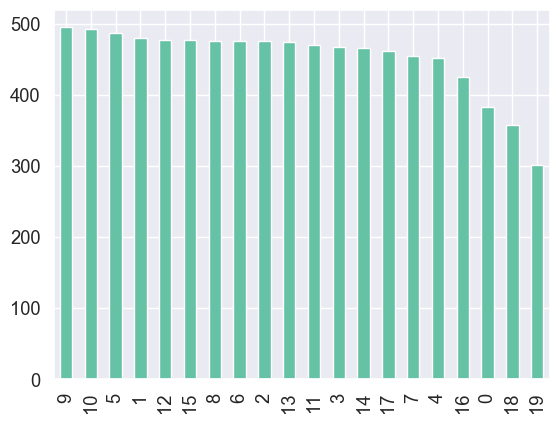

In [10]:
counts = pd.value_counts(train['target'], sort=True)
counts.plot(kind='bar')

Из графика видно, что класс 19, т.е. 'talk.religion.misc', сильно меньше, чем класса 9('rec.sport.baseball'). Но график не сильно информативен, так как слов в каждом сообщении достаточно много

Посмотрим на длину каждой новости:

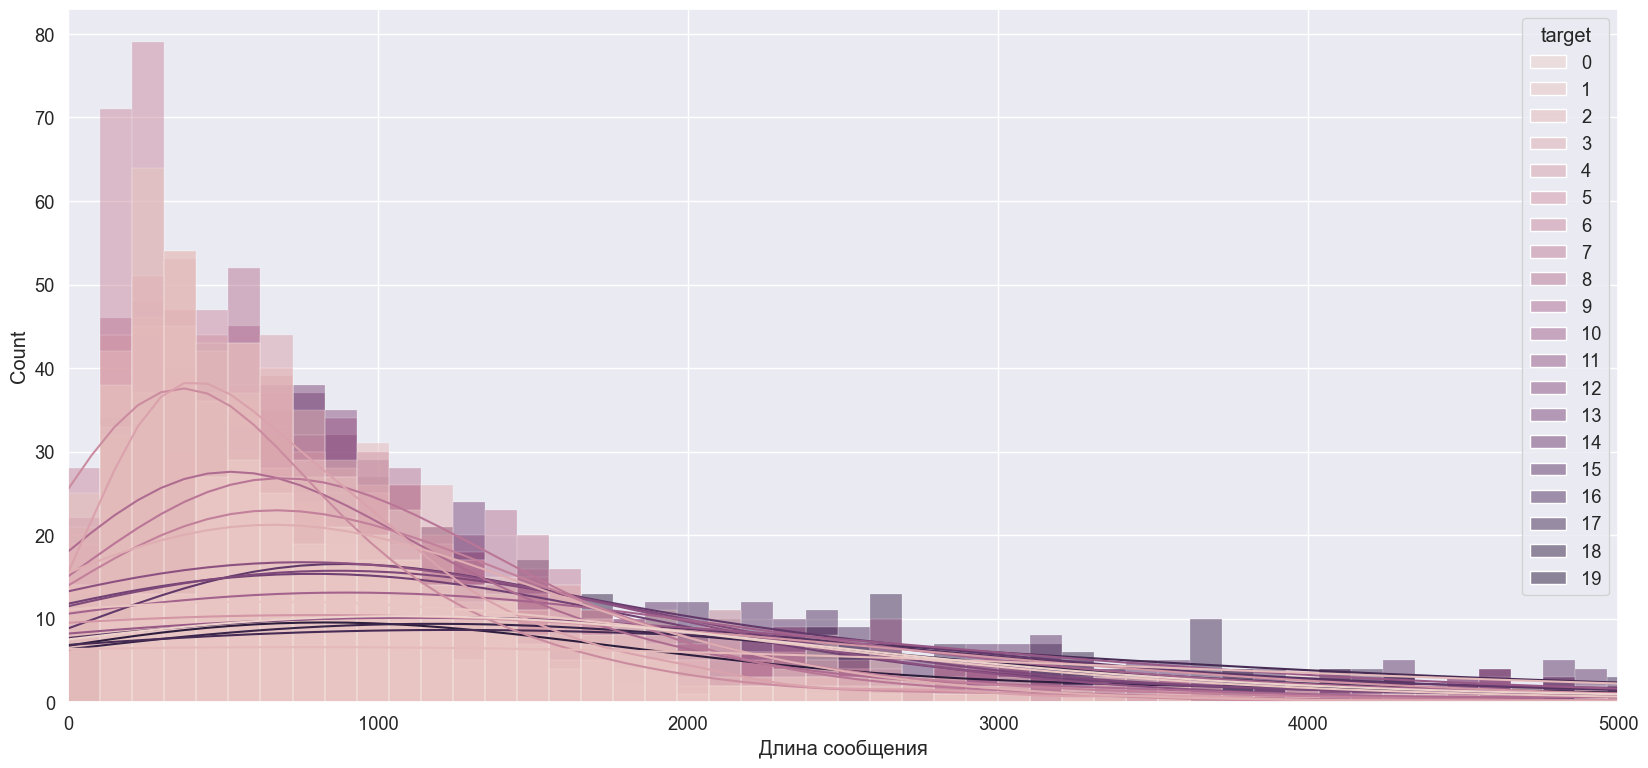

In [11]:
plt.figure(figsize=(20, 9))
sns.histplot(x=train['news'].apply(len), 
             hue=train['target'], 
             kde=True, common_norm=False,
             kde_kws=dict(gridsize=1000))
plt.xlim((0, 5000))
plt.xlabel('Длина сообщения');

График получился очень не информативным, так как очень много классов и они перекрыли друг друга.

Теперь давайте потбирать гиперпараметров тем же способом, что мы делали в работе про решающие деревья: Обучать и смотреть на ошибку, которую мы получим.

In [13]:
error = []

for max_d in np.arange(0.011, 0.075, 0.001):
    # Зафиксируем min_def= 0.05
    vectorizer = CountVectorizer(min_df=0.01, max_df=max_d)
    vec_data_train = vectorizer.fit_transform(train['news']).toarray()
    vec_test = vectorizer.transform(val['news']).toarray()

    multinomial_nb = MultinomialNB()
    multinomial_nb.fit(vec_data_train, train['target'])

    predictions = multinomial_nb.predict(vec_test)
    error.append(accuracy_score(val['target'], predictions))

Text(0.5, 1.0, 'Зависимости ошибки от максимальной частоты слова')

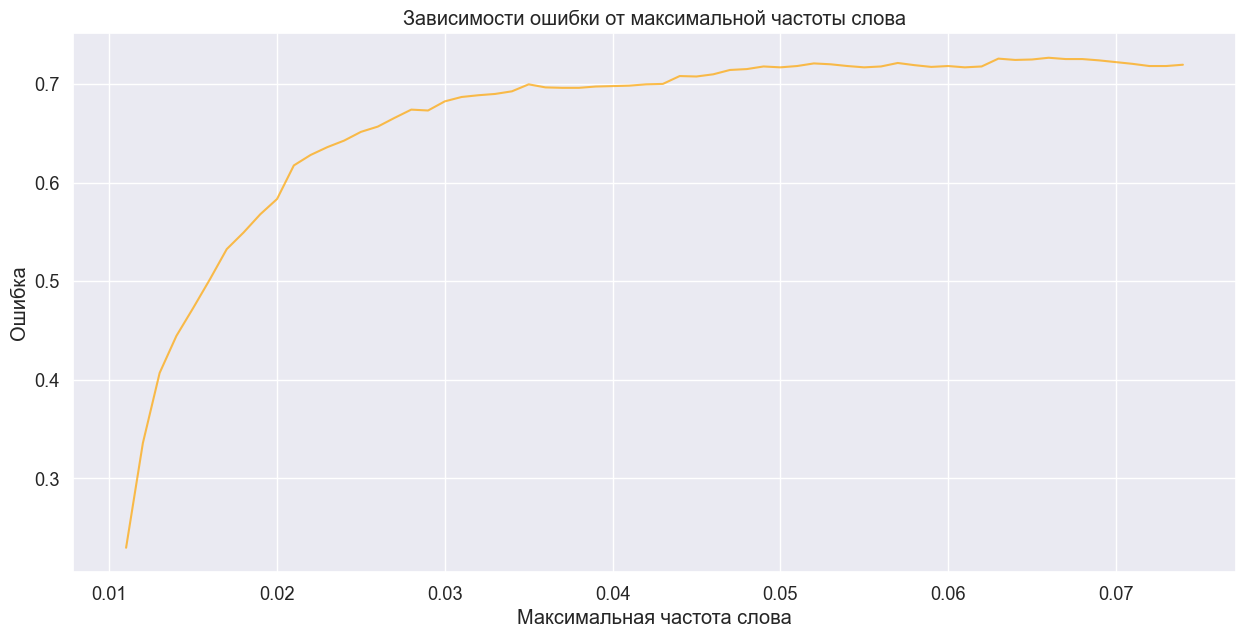

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0.011, 0.075, 0.001), error, color='orange', alpha=0.7)
plt.xlabel('Максимальная частота слова')
plt.ylabel('Ошибка')
plt.title('Зависимости ошибки от максимальной частоты слова')

Выберем максимальную частоту слова, следуюющим 0.03.

И теперь для этого значения подберем минимальную частоту слова, тем же способом

In [11]:
error1 = []

for min_d in np.arange(0, 0.03, 0.001):
    vectorizer = CountVectorizer(min_df=min_d, max_df=0.03)
    vec_data_train = vectorizer.fit_transform(val['news']).toarray()
    vec_test = vectorizer.transform(train['news']).toarray()

    multinomial_nb = MultinomialNB()
    multinomial_nb.fit(vec_data_train, val['target'])
    
    predictions = multinomial_nb.predict(vec_test)
    error1.append(accuracy_score(train['target'], predictions))
error1

[0.7191470555739697,
 0.7211357861009833,
 0.7256656723014031,
 0.7053364269141531,
 0.6837918462048392,
 0.6739586785990498,
 0.6566125290023201,
 0.6346260081758922,
 0.622141199867418,
 0.603690199977903,
 0.5897690862888079,
 0.5720914816042426,
 0.5528670865097779,
 0.5364048171472765,
 0.5262401944536516,
 0.5157441166721909,
 0.5030383383051596,
 0.4911059551430781,
 0.4651419732626229,
 0.446911943431665,
 0.41431885979449784,
 0.39597834493426143,
 0.3665893271461717,
 0.3307921776599271,
 0.28648768091923543,
 0.2624019445365153,
 0.23610650756822452,
 0.16848966964976245,
 0.144956358413435,
 0.11037454424925422]

Text(0.5, 1.0, 'Зависимости ошибки от минимальной частоты слова')

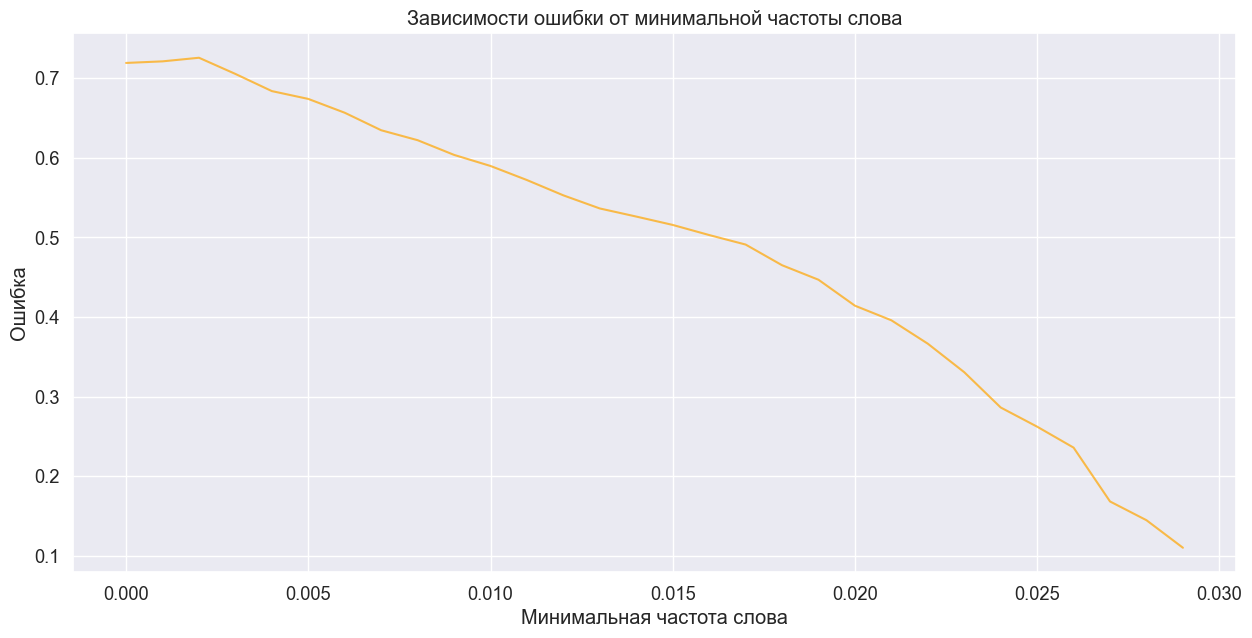

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, 0.03, 0.001), error1, color='orange', alpha=0.7)
plt.xlabel('Минимальная частота слова')
plt.ylabel('Ошибка')
plt.title('Зависимости ошибки от минимальной частоты слова')

Выберем минимальную частоту слова, следуюющим 0.005.

Посчитайте качество на тестовой выборке.

In [15]:
vectorizer = CountVectorizer(min_df=0.005, max_df=0.3)
vec_data_train = vectorizer.fit_transform(train['news']).toarray()
vec_test = vectorizer.transform(data_test['data']).toarray()

multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, train['target'])

predictions = multinomial_nb.predict(vec_test)
print(accuracy_score(data_test['target'], predictions))

0.678040361125863


Выводы: Обученная модель предсказывает классы с достаточной неплохой точностью. При этом при подборе гипперрпараметров видно, что большинство смысловых слов встречается реже, чем связующие или несмысловые.

---
### Задача 2.
Пусть $\mathscr{X} = \mathbb{R}^2$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ. Условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.

*Примечание.* Можно подобрать выборку, посчитать оценки со страшными числами. Но еще лучше &mdash; немного подумать и привести пример с "красивыми" числами без какого-либо подбора выборки. В данном случае это довольно просто, а также позволяет лучше разобраться в параметрах многомерного нормального распределения.